In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from block_ai.lib.myblokus.piece import Piece
from block_ai.lib.myblokus.point import Point
from block_ai.lib.myblokus.orientation import Orientation
from sklearn.preprocessing import normalize
from block_ai.lib.myblokus import point
import logging
logging.basicConfig(level=logging.DEBUG)

In [2]:
corner1 = [Point(-1, -1), Point(0, 0)]
corner2 = [Point(2, -1), Point(1, 0)]

## Visualization

In [3]:
class PieceVisualization:
    EMPTY = 0
    FULL = 1
    BORDER = 2
    PLAYABLE = 3
    START = 4
    
    def __init__(self):
        pass
    
    def fill(self, point, value):
        x, y = self.get_indices(point)
        self.matrix[x, y] = value
        
    def get_indices(self, point):
        return point.x + 5, point.y + 5
    
    def display(self, orientation):
        self.init_matrix()
        self.fill_in_points(orientation)
        self.gen_graph()

    def init_matrix(self):
        self.x = [str(x) for x in range(-5, 6)]
        self.y = [str(x) for x in range(-5, 6)]
        matrix = []
        for x in self.x:
            sub = [self.EMPTY for y in self.y]
            matrix.append(sub)
        self.matrix = np.matrix(matrix)

    def fill_in_points(self, orientation):
        for p in orientation.points:
            self.fill(p, self.FULL)

        for p in orientation.get_corner_points():
            self.fill(p, self.PLAYABLE)
        
        for p in orientation.get_border_points():
            self.fill(p, self.BORDER)
            
        self.fill(Point(-1, -1), self.START)

    def gen_graph(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(self.matrix)
        plt.show()

## Sandbox

In [4]:
p1 = Piece([Point(0, 0)])
p2 = Piece([Point(0, 0), Point(0, 1)])
p3 = Piece([Point(0, 0), Point(0, 1), Point(0, 2)])
p4 = Piece([Point(0, 0), Point(0, 1), Point(1, 1)])
p5 = Piece([Point(0, 0), Point(1, 0), Point(0, 1), Point(1, 1)])
p6 = Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0)])
p7 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)])
p8 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 0)])

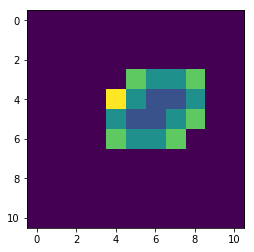

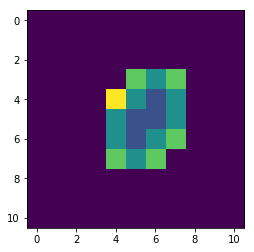

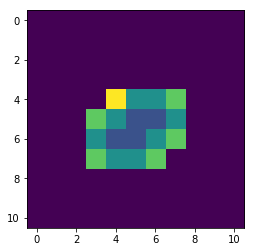

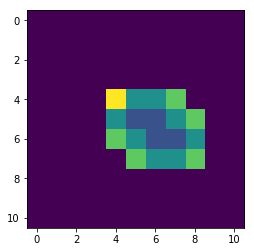

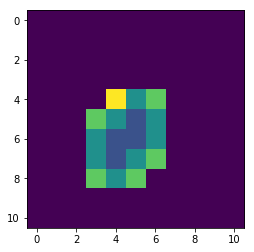

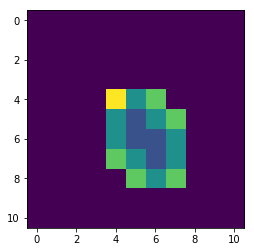

In [5]:
p = p7
vis = PieceVisualization()
for o in p.orientations:
    vis.display(o)

In [7]:
p4

Piece(Orientation((Point(-1, 1), Point(0, 0), Point(0, 1))),
Orientation((Point(0, 0), Point(0, 1), Point(1, 0))),
Orientation((Point(0, 0), Point(0, 1), Point(1, 1))),
Orientation((Point(0, 0), Point(1, -1), Point(1, 0))),
Orientation((Point(0, 0), Point(1, 0), Point(1, 1))))

In [8]:
Piece(Orientation((Point(-1, 1), Point(0, 0), Point(0, 1))),
Orientation((Point(0, 0), Point(0, 1), Point(1, 0))),
Orientation((Point(0, 0), Point(0, 1), Point(1, 1))),
Orientation((Point(0, 0), Point(1, -1), Point(1, 0))),
Orientation((Point(0, 0), Point(1, 0), Point(1, 1))))

TypeError: __init__() takes 2 positional arguments but 6 were given

In [9]:
str(p1)

'(Point(0, 0),)'